# The dataset

https://snap.stanford.edu/data/email-Eu-core.html

The network was generated using email data from a large European research institution. We have anonymized information about all incoming and outgoing email between members of the research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.


In [1]:
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\aligh\AppData\Local\Temp\ipykernel_19784\206557912.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# # Create a SparkContext
# sc = SparkContext()

# # Create a SparkSession
# spark = SparkSession.builder.getOrCreate('CommunityDetection', sc)


## Step 1: Load the Data

In [3]:
# Load email communications
emails_df = pd.read_csv('data/email-Eu-core.txt', sep=' ', header=None, names=['sender', 'receiver'])

# Load department labels
departments_df = pd.read_csv('data/email-Eu-core-department-labels.txt', sep=' ', header=None, names=['member', 'department'])
# Add department labels as node attributes
department_dict = departments_df.set_index('member')['department'].to_dict()

## Step 2: Build the graph

#### Filter the recursive nodes

In [4]:
emails_df = emails_df[emails_df['sender'] != emails_df['receiver']]
emails_df.head()

,sender,receiver
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7


#### Let us test that graph is successfully built by a small sample `nodeId` [0-5]

In [5]:
filtered_emails_df = emails_df[(emails_df['sender'] >= 0) & (emails_df['sender'] <= 5) & (emails_df['receiver'] >= 0) & (emails_df['receiver'] <= 5)]
filtered_emails_df


,sender,receiver
0,0,1
1,2,3
2,2,4
138,4,2
139,4,3
1212,3,2
1838,3,4
3485,5,2
5183,2,5
14670,0,5


In [6]:
def build_graph_from_adjacency_list(adj_df, departments_df):
        
    G = nx.from_pandas_edgelist(adj_df, 'sender', 'receiver')
    nx.set_node_attributes(G, department_dict, 'department')

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
    return G

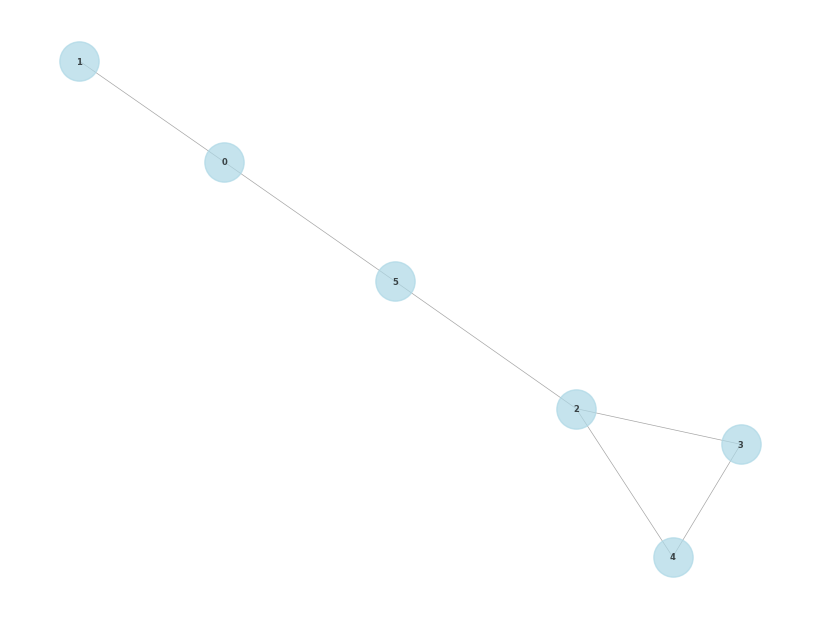

In [7]:
G = build_graph_from_adjacency_list(filtered_emails_df, departments_df)

### Now let us create full graph of the data

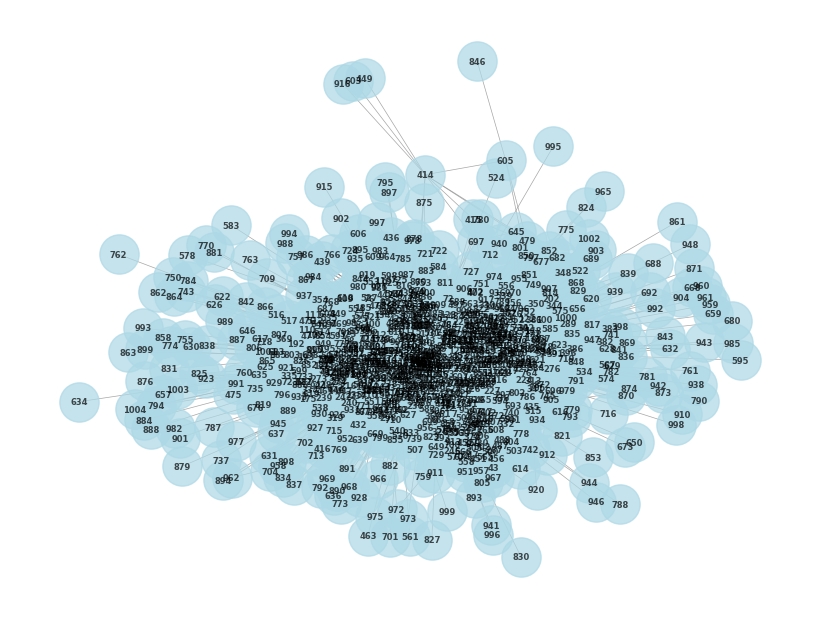

In [8]:
G = build_graph_from_adjacency_list(emails_df, departments_df)

### Let us plot the distribution of the departments

In [9]:
from collections import Counter

department_counts = Counter(department_dict.values())
print(department_counts)


Counter({4: 109, 14: 92, 1: 65, 21: 61, 15: 55, 7: 51, 0: 49, 10: 39, 17: 35, 9: 32, 11: 29, 19: 29, 6: 28, 23: 27, 13: 26, 22: 25, 16: 25, 36: 22, 8: 19, 5: 18, 37: 15, 20: 14, 34: 13, 38: 13, 35: 13, 3: 12, 27: 10, 2: 10, 26: 9, 32: 9, 28: 8, 31: 8, 25: 6, 24: 6, 29: 5, 40: 4, 30: 4, 39: 3, 12: 3, 41: 2, 18: 1, 33: 1})


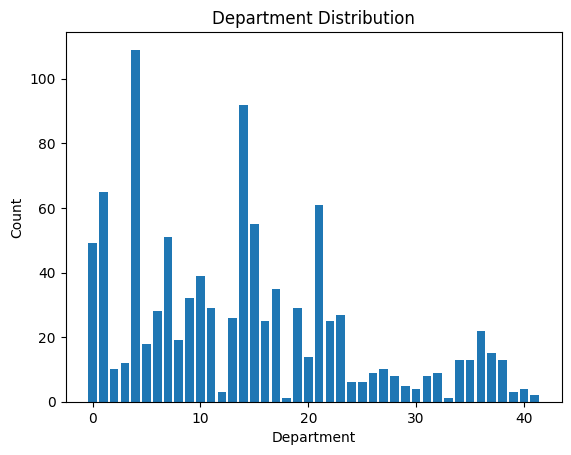

In [10]:
plt.bar(department_counts.keys(), department_counts.values())
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department Distribution')
plt.show()


To retrieve the department of associated node

In [11]:
nodeId = 2
department = G.nodes[nodeId]['department']
print(f"The department of node {nodeId} is {department}")


The department of node 2 is 21


## Step 4: Extract the Adjacency Matrix

*Notice:* The data is inclusive of recursive nodes

In [12]:
adjacency_matrix = nx.adjacency_matrix(G)

# Convert the adjacency matrix to a dense format for display purposes
adjacency_matrix_dense = adjacency_matrix.todense()

# Display the adjacency matrix as a DataFrame for better readability
df_adjacency_matrix = pd.DataFrame(adjacency_matrix_dense, index=G.nodes(), columns=G.nodes())
df_adjacency_matrix

C:\Users\aligh\AppData\Local\Temp\ipykernel_19784\1264560264.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


,0,1,2,3,4,5,6,7,8,9,...,996,997,763,998,999,1000,1001,1002,1003,1004
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Louvain Algorithm

## Introduction
The Louvain algorithm is a community detection algorithm designed for large networks. It aims to maximize the modularity score for each community, evaluating how densely connected nodes are within a community compared to random networks. More information on the Louvain method can be found [here](https://en.wikipedia.org/wiki/Louvain_method).

## Library
Community detection will be performed using the [community](https://python-louvain.readthedocs.io/en/latest/api.html) library in conjunction with NetworkX.

## Steps

### Finding Communities
In this phase, the algorithm follows these steps:
1. **Initialization**: Each node is initially assigned to its own community.
2. **Modularity Optimization**: For each node, the algorithm seeks the maximum positive modularity gain by exploring potential moves to all neighbor communities. If no positive gain is achieved, the node remains in its original community.
######  **Assign final results**: finally we will assign each node it's community as an attribute to be used later
### Displaying the Results
This section showcases the community results in two ways:

- **Static Display**: All nodes are visualized in a single image, with each community represented by a distinct color.
- **Interactive Display**: Utilizing the *pyvis* library, an interactive page is generated to display the top-10 nodes within each community.

For more detailed information, please refer to the code documentation.


#### Finding Communities

In [13]:
# louvain community detection
from community import community_louvain
partition = community_louvain.best_partition(G)


#### add community as attribure


In [14]:
# Add the partition as a node attribute
nx.set_node_attributes(G, partition, 'louvain_community')

In [15]:
# show the number of communities
num_communities = len(set(partition.values()))
print(f"The number of communities detected is {num_communities}")

The number of communities detected is 7


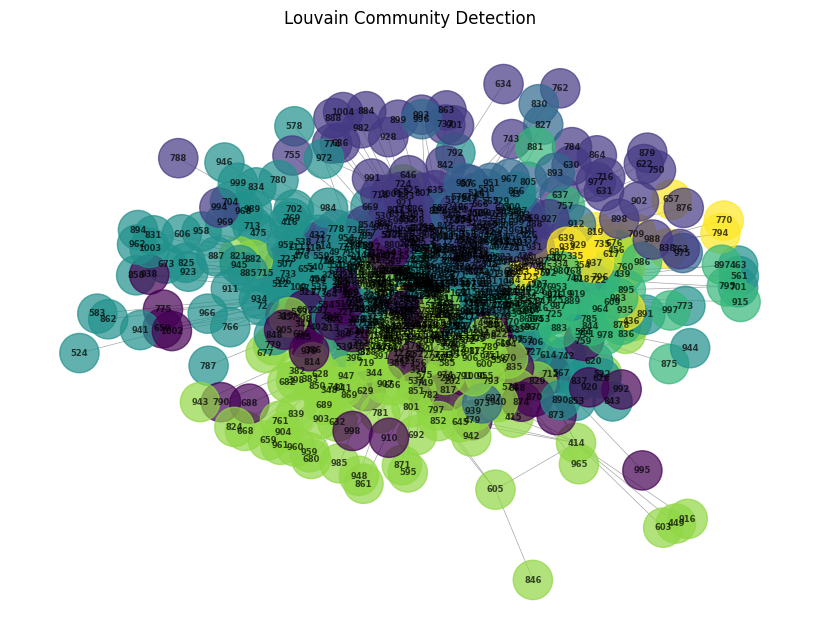

In [16]:
# Create a list of colors for the nodes based on their community
colors = [partition[n] for n in G.nodes()]
# Draw the graph with the colors
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors, edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
plt.title('Louvain Community Detection')
plt.show()

#### Visalization for the Graph
<small>The following code will generate an html webpage with needed information in *./lib* directry 
- You need LiveServer install in order to visualize the results
- once the *Louvain.html* is created
    - go to the directory *./Louvain.html* 
    - start LiveServer
    </small>

In [17]:
# provide zoomable graph for better visualization
import pyvis
from pyvis.network import Network
net = Network(notebook=True)
# get top 10 nodes for each community
top_nodes = {community: [] for community in set(partition.values())}
for node, community in partition.items():
    if len(top_nodes[community]) < 10:
        top_nodes[community].append(node)
# add the nodes and edges to the network with colors
for community, nodes in top_nodes.items():
    for node in nodes:
        net.add_node(node, label=node)
    for sender, receiver in G.edges():
        if sender in nodes and receiver in nodes:
            net.add_edge(sender, receiver)
# build a color map for the nodes based on their community with hex colors
color_map = {community: f"#{np.random.choice(range(256**3)):06x}" for community in set(partition.values())}
# for each node in the network, add the color and size to the node
for node in net.nodes:
    node['color'] = color_map.get(colors[node['id']])
    node['size'] = 10

# show the network
net.show("Louvain.html")


Louvain.html


In [18]:
# make a table for the top_nodes with it's communities 
# show node_id, community, department
top_nodes_df = pd.DataFrame(columns=['node_id', 'community', 'department'])
for community, nodes in top_nodes.items():
    for node in nodes:
        top_nodes_df = pd.concat([top_nodes_df, pd.DataFrame({'node_id': node, 'community': community, 'department': G.nodes[node]['department']}, index=[0])], ignore_index=True)
top_nodes_df

,node_id,community,department
0,0,0,1
1,1,0,1
2,17,0,1
3,18,0,1
4,65,0,4
...,...,...,...
65,99,6,16
66,100,6,16
67,101,6,16
68,124,6,16


In [19]:
# show number of communities, number of departments, number of nodes
num_communities = len(set(partition.values()))
num_departments = len(set(department_dict.values()))
num_nodes = len(G.nodes())
print(f"The number of communities detected is {num_communities}")
print(f"The number of departments is {num_departments}")
print(f"The number of nodes is {num_nodes}")

The number of communities detected is 7
The number of departments is 42
The number of nodes is 986


In [20]:
# show the department for each community
community_departments = {community: [] for community in set(partition.values())}
for node, community in partition.items():
    if G.nodes[node]['department'] not in community_departments[community]:
        community_departments[community].append(G.nodes[node]['department'])
# show the department for each community pretty
for community, departments in community_departments.items():
    print(f"Community {community} has departments {departments}")

# show for each community the node's id
community_nodes = {community: [] for community in set(partition.values())}
for node, community in partition.items():
    community_nodes[community].append(node)
# show for each community the node's id
for community, nodes in community_nodes.items():
    print(f"Community {community} has nodes {nodes}")
    

Community 0 has departments [1, 4, 15, 0, 39, 13, 6, 31, 23, 41, 33, 14]
Community 1 has departments [21, 25, 22, 20, 38, 28, 19, 32, 36, 1, 6, 24, 16, 17, 30, 4, 29, 34]
Community 2 has departments [14, 15, 32, 9]
Community 3 has departments [9, 34, 36, 37, 8, 15, 3, 29, 38, 27, 6, 26, 2, 40, 35, 23, 24, 14, 31, 4, 16, 30, 22, 25, 21, 17, 10, 7, 41]
Community 4 has departments [26, 11, 10, 4, 20, 13, 12, 22, 36, 18, 31, 9]
Community 5 has departments [4, 5, 7, 25, 0, 36, 1, 3, 6, 15, 26, 13, 20, 23, 21, 24]
Community 6 has departments [17, 16, 26, 4, 25]
Community 0 has nodes [0, 1, 17, 18, 65, 73, 74, 85, 120, 129, 146, 168, 172, 176, 177, 183, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 248, 257, 268, 270, 275, 276, 291, 294, 297, 307, 309, 310, 311, 312, 313, 314, 315, 316, 317, 330, 331, 341, 399, 401, 403, 413, 425, 426, 435, 440, 450, 457, 458, 459, 468, 479, 493, 507, 515, 526, 534, 542, 543, 544, 560, 568, 574, 576, 562, 600, 611, 616, 585, 629, 650, 664, 688, 

C:\Users\aligh\AppData\Local\Temp\ipykernel_19784\3744985461.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  community_adjacency_matrix = nx.adjacency_matrix(G)
c:\Users\aligh\anaconda3\envs\mgma_community\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


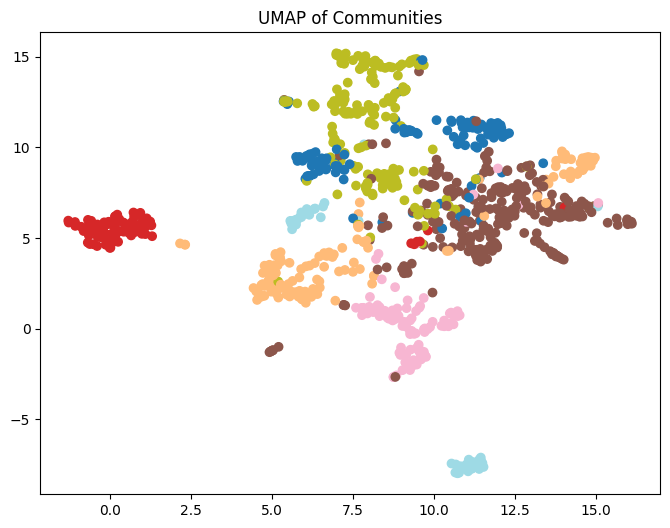

In [21]:
# get adjacency matrix for the communities
community_adjacency_matrix = nx.adjacency_matrix(G)
# Convert the adjacency matrix to a dense format for display purposes
community_adjacency_matrix_dense = np.asarray(community_adjacency_matrix.todense())
# build a umap for the communities and plot it
import umap
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(community_adjacency_matrix_dense)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab20')
plt.title('UMAP of Communities')
plt.show()

# Leiden algorithm

The Leiden algorithm is an algorithm for detecting communities in large networks. The algorithm separates nodes into disjoint communities so as to maximize a modularity score for each community. Modularity quantifies the quality of an assignment of nodes to communities, that is how densely connected nodes in a community are, compared to how connected they would be in a random network.

The Leiden algorithm is a hierarchical clustering algorithm, that recursively merges communities into single nodes by greedily optimizing the modularity and the process repeats in the condensed graph. It modifies the Louvain algorithm to address some of its shortcomings, namely the case where some of the communities found by Louvain are not well-connected. This is achieved by periodically randomly breaking down communities into smaller well-connected ones.

In [22]:
import leidenalg
import igraph as ig

In [23]:
ledian_partion = leidenalg.find_partition(ig.Graph.TupleList(G.edges()), leidenalg.ModularityVertexPartition, n_iterations=-1)

In [24]:
# show the number of communities in leiden
num_communities_leiden = len(ledian_partion)
print(f"The number of communities detected using Leiden is {num_communities_leiden}")

The number of communities detected using Leiden is 8


In [25]:
# Add the partition as a node attribute
nx.set_node_attributes(G, ledian_partion.membership, 'leiden_community')


In [26]:
community_departments_leiden = {community: [] for community in range(len(ledian_partion))}
for community in range(len(ledian_partion)):
    for node in ledian_partion.subgraphs()[community].vs['name']:
        if G.nodes[node]['department'] not in community_departments_leiden[community]:
            community_departments_leiden[community].append(G.nodes[node]['department'])
# show the department for each community pretty
for community, departments in community_departments_leiden.items():
    print(f"Community {community} has departments {departments}")

# show for community the node id's 
top_nodes_leiden = {community: [] for community in range(len(ledian_partion))}
for community in range(len(ledian_partion)):
    for node in ledian_partion.subgraphs()[community].vs['name']:
        top_nodes_leiden[community].append(node)
# show the top nodes for each community pretty
for community, nodes in top_nodes_leiden.items():
    print(f"Community {community} has nodes {nodes}")

    
    

Community 0 has departments [23, 15, 38, 9, 36, 40, 35, 31, 6, 37, 34, 25, 14, 26, 4, 8, 2, 22, 30, 3, 24, 29, 18, 27, 7, 10, 17, 41, 21]
Community 1 has departments [3, 0, 25, 4, 5, 36, 2, 1, 21, 33, 14, 26, 6, 15]
Community 2 has departments [20, 25, 19, 21, 38, 22, 32, 1, 28, 36, 0, 4, 29, 34, 6, 17, 24, 30]
Community 3 has departments [26, 10, 20, 36, 13, 11, 22, 12, 4, 6, 9, 16, 31]
Community 4 has departments [14, 32, 35, 36, 20, 15, 4, 9]
Community 5 has departments [1, 15, 39, 31, 36, 7, 6, 23, 26, 0, 41, 13, 24, 21]
Community 6 has departments [1, 7, 36, 0, 6, 26, 4]
Community 7 has departments [16, 17]
Community 0 has nodes [495, 549, 147, 106, 21, 82, 254, 155, 189, 726, 548, 255, 187, 127, 121, 84, 641, 142, 434, 160, 162, 300, 489, 612, 249, 107, 62, 546, 651, 896, 405, 256, 81, 932, 473, 282, 424, 431, 145, 329, 117, 327, 105, 357, 279, 669, 42, 730, 306, 492, 134, 419, 828, 469, 375, 184, 154, 420, 462, 325, 445, 728, 163, 690, 230, 667, 418, 79, 299, 112, 422, 212, 10, 

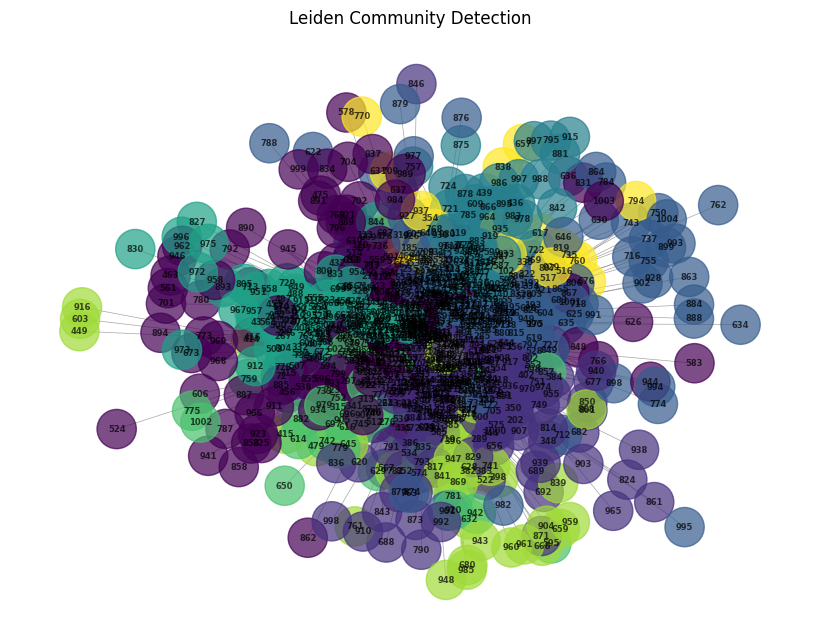

In [27]:
# Create a list of colors for the nodes based on their community
colors_leiden =  []
for node in G.nodes():
    for community in range(len(ledian_partion)):
        if node in ledian_partion.subgraphs()[community].vs['name']:
            colors_leiden.append(community)
            break
# Draw the graph with the colors
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors_leiden, edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
plt.title('Leiden Community Detection')
plt.show()


# ADD INTERACTIVE MIR

C:\Users\aligh\AppData\Local\Temp\ipykernel_19784\1363361484.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  community_adjacency_matrix_leiden = nx.adjacency_matrix(G)


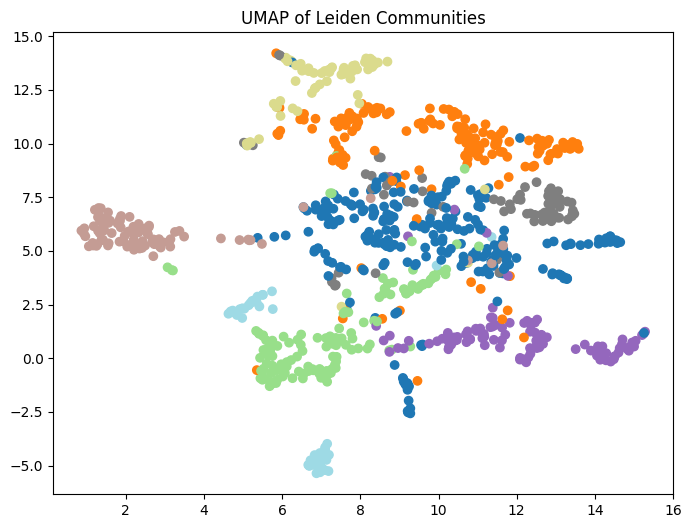

In [28]:
# get adjacency matrix for the leiden communities
community_adjacency_matrix_leiden = nx.adjacency_matrix(G)
# Convert the adjacency matrix to a dense format for display purposes
community_adjacency_matrix_dense_leiden = np.asarray(community_adjacency_matrix_leiden.todense())
# make umap for the leiden communities
embedding_leiden = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(community_adjacency_matrix_dense_leiden)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_leiden[:, 0], embedding_leiden[:, 1], c=colors_leiden, cmap='tab20')
plt.title('UMAP of Leiden Communities')
plt.show()


# Comperison between the algorithms 
###  make some statistics comperisons + visualization using umap

In [29]:
# compare the number of communities detected by Louvain, and Leiden
print(f"The number of communities detected using Louvain is {num_communities}")
print(f"The number of communities detected using Leiden is {num_communities_leiden}")
# extract the communities detected by Louvain and Leiden for comparison
louvain_communities = set(partition.values())
leiden_communities = set(ledian_partion.membership)
# show the number of communities detected by both algorithms
num_common_communities = len(louvain_communities.intersection(leiden_communities))
print(f"The number of communities detected by both Louvain and Leiden is {num_common_communities}")

# show the number of nodes in each community
louvain_community_sizes = Counter(partition.values())
leiden_community_sizes = Counter(ledian_partion.membership)
# show the number of nodes in each community pretty
for community, size in louvain_community_sizes.items():
    print(f"Louvain community {community} has {size} nodes")
for community, size in leiden_community_sizes.items():
    print(f"Leiden community {community} has {size} nodes")

# show the number of nodes in each community
louvain_community_sizes = Counter(partition.values())
leiden_community_sizes = Counter(ledian_partion.membership)
# show the number of nodes in each community pretty
for community, size in louvain_community_sizes.items():
    print(f"Louvain community {community} has {size} nodes")
for community, size in leiden_community_sizes.items():
    print(f"Leiden community {community} has {size} nodes")

# save the data for communities detected by Louvain and Leiden in a csv file
louvain_community_df = pd.DataFrame(louvain_community_sizes.items(), columns=['community', 'size'])
louvain_community_df['algorithm'] = 'Louvain'
leiden_community_df = pd.DataFrame(leiden_community_sizes.items(), columns=['community', 'size'])
leiden_community_df['algorithm'] = 'Leiden'
community_df = pd.concat([louvain_community_df, leiden_community_df])
community_df.to_csv('./data/communities.csv', index=False)



The number of communities detected using Louvain is 7
The number of communities detected using Leiden is 8
The number of communities detected by both Louvain and Leiden is 7
Louvain community 0 has 123 nodes
Louvain community 1 has 147 nodes
Louvain community 2 has 91 nodes
Louvain community 3 has 273 nodes
Louvain community 4 has 110 nodes
Louvain community 5 has 185 nodes
Louvain community 6 has 57 nodes
Leiden community 5 has 76 nodes
Leiden community 1 has 173 nodes
Leiden community 6 has 72 nodes
Leiden community 4 has 96 nodes
Leiden community 7 has 55 nodes
Leiden community 2 has 146 nodes
Leiden community 0 has 259 nodes
Leiden community 3 has 109 nodes
Louvain community 0 has 123 nodes
Louvain community 1 has 147 nodes
Louvain community 2 has 91 nodes
Louvain community 3 has 273 nodes
Louvain community 4 has 110 nodes
Louvain community 5 has 185 nodes
Louvain community 6 has 57 nodes
Leiden community 5 has 76 nodes
Leiden community 1 has 173 nodes
Leiden community 6 has 72 nod

In [30]:
# show the difference in the number of communities detected by Louvain and Leiden
num_communities_difference = abs(num_communities - num_communities_leiden)
print(f"The difference in the number of communities detected by Louvain and Leiden is {num_communities_difference}")


The difference in the number of communities detected by Louvain and Leiden is 1


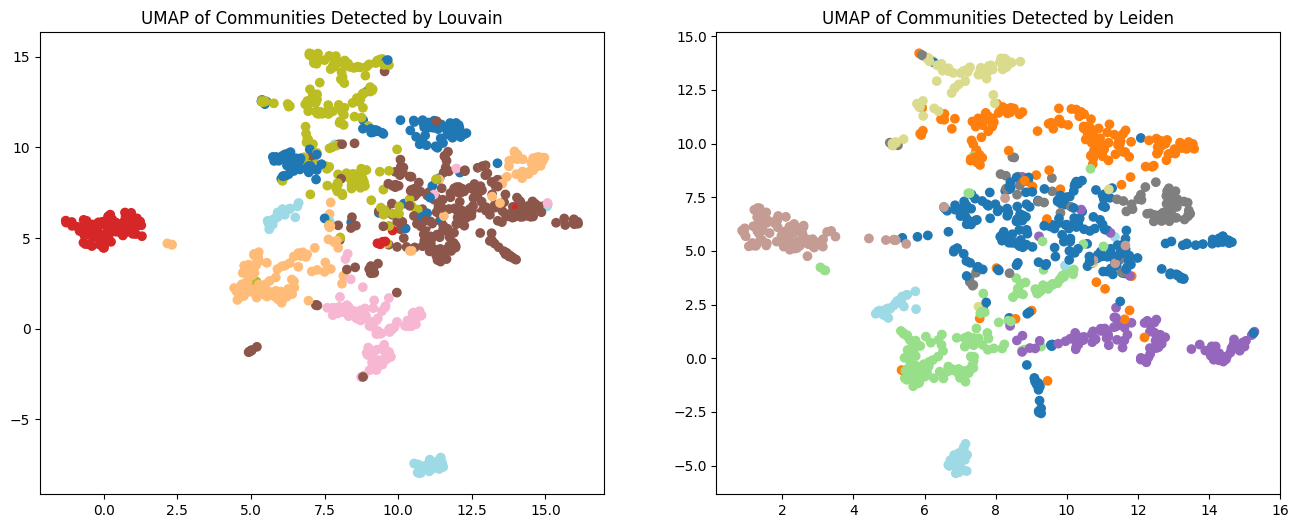

In [31]:
# draw 2 umap for the communities detected by Louvain and Leiden next to each other
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab20')
ax[0].set_title('UMAP of Communities Detected by Louvain')
ax[1].scatter(embedding_leiden[:, 0], embedding_leiden[:, 1], c=colors_leiden, cmap='tab20')
ax[1].set_title('UMAP of Communities Detected by Leiden')
plt.show()


####  Modularity by algorithms
* It measures the extent to which the network can be divided into distinct communities based on the observed connectivity patterns, and it compares the number of edges within communities to the expected number of edges in a random network with the same node degrees.
* Modularity = Q = (1 / (2m)) * Σᵢⱼ [Aᵢⱼ - (kᵢ * kⱼ) / (2m)] * δ(cᵢ, cⱼ)

where:
- `Q`: Modularity, a measure of the quality of the partition into communities.

- `A_{ij}`: The entry in the adjacency matrix representing the connection between nodes i and j.

- `k_i` and `k_j`: The degrees (total number of edges) of nodes i and j, respectively.

- `m`: The total number of edges in the network.

- `δ(c_i, c_j)`: Kronecker delta function, which equals 1 if nodes i and j are in the same community (c_i = c_j) and 0 otherwise.

* The goal is to find a partition of nodes into communities that maximizes this modularity value, indicating a stronger community structure within the network.


In [32]:
# calculate the modularity for the communities detected by Louvain and Leiden
modularity_louvain = community_louvain.modularity(partition, G)
modularity_leiden = leidenalg.ModularityVertexPartition(ig.Graph.TupleList(G.edges())).quality()
print(f"The modularity of the communities detected by Louvain is {modularity_louvain}")
print(f"The modularity of the communities detected by Leiden is {modularity_leiden}")


The modularity of the communities detected by Louvain is 0.40675404550870226
The modularity of the communities detected by Leiden is -0.0023237168358439093


#### Density of the communities by the algorithms
* The density of a community is typically defined as the ratio of the number of edges within the community to the total number of possible edges within that community. Mathematically, it can be expressed as follows:
* Density = (2 * number of intra-community edges) / (number of nodes in the community * (number of nodes in the community - 1))
* The density value ranges from 0 to 1, where a higher density indicates a more connected and compact community. 


In [33]:
# calcualte the density for the communities detected by Louvain and Leiden
density_louvain = nx.density(G.subgraph([node for node, community in partition.items() if community == 0]))
density_leiden = nx.density(G.subgraph([node for node, community in enumerate(ledian_partion.membership) if community == 0]))
print(f"The density of the communities detected by Louvain is {density_louvain}")
print(f"The density of the communities detected by Leiden is {density_leiden}")


The density of the communities detected by Louvain is 0.10635745701719312
The density of the communities detected by Leiden is 0.030393574297188756


#### Cut ratio by the algorithms
* Cut Ratio = Σᵢⱼ wᵢⱼ * indicator(Cᵢ ≠ Cⱼ) / min(Σᵢ dᵢ, Σᵢ ḋᵢ)
where:

    * wᵢⱼ is the weight of the edge between nodes i and j,
    * Cᵢ is the community label of node i,
    * dᵢ is the total edge weight for nodes in the same community as node i,
    * ḋᵢ is the total edge weight for nodes in the opposite community of node i.
* The cut ratio is the ratio of the number of edges leaving the community to the volume of the community, where the volume of the community is the sum of the degrees of the nodes in the community, and the number of edges leaving the community is the number of edges with one endpoint in the community and one endpoint outside the community.


In [34]:
# calculate the cut ratio for the communities detected by Louvain and Leiden
# cut ratio the better is the 
cut_ratio_louvain = nx.cut_size(G, [node for node, community in partition.items() if community == 0]) / nx.volume(G, [node for node, community in partition.items() if community == 0])
cut_ratio_leiden = nx.cut_size(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0]) / nx.volume(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The cut ratio of the communities detected by Louvain is {cut_ratio_louvain}")
print(f"The cut ratio of the communities detected by Leiden is {cut_ratio_leiden}")


The cut ratio of the communities detected by Louvain is 0.5487701441899915
The cut ratio of the communities detected by Leiden is 0.7494039735099338


#### Normalized Cut by the algorithms

* Normalized Cut = Σᵢⱼ wᵢⱼ * indicator(Cᵢ ≠ Cⱼ) / Σᵢ dᵢ
where:

    * wᵢⱼ is the weight of the edge between nodes i and j,
    * Cᵢ is the community label of node i,
    * dᵢ is the degree (total edge weight) of node i.

* the normalized cut is the fraction of the total edge volume that points outside the community, normalized by the volume of the community.
* A high normalized cut value suggests a good separation between communities.



In [35]:
# calcualte the normalized cut for the communities detected by Louvain and Leiden
normalized_cut_louvain = nx.normalized_cut_size(G, [node for node, community in partition.items() if community == 0])
normalized_cut_leiden = nx.normalized_cut_size(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The normalized cut of the communities detected by Louvain is {normalized_cut_louvain}")
print(f"The normalized cut of the communities detected by Leiden is {normalized_cut_leiden}")

The normalized cut of the communities detected by Louvain is 0.6166586405699711
The normalized cut of the communities detected by Leiden is 0.9796098486828526


#### Calculate Conductance for the communinities
* This conductance represents the fraction of the total edge volume that points outside the community, lower conductance is better
* A low cut ratio value indicates a good separation between communities.


In [36]:
# calculate the conductance for the communities detected by Louvain and Leiden
# this conductance represents the fraction of the total edge volume that points outside the community, lower conductance is better
conductance_louvain = nx.conductance(G, [node for node, community in partition.items() if community == 0])
conductance_leiden = nx.conductance(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The conductance of the communities detected by Louvain is {conductance_louvain}")
print(f"The conductance of the communities detected by Leiden is {conductance_leiden}")

The conductance of the communities detected by Louvain is 0.5487701441899915
The conductance of the communities detected by Leiden is 0.7494039735099338


# ML Algorithm 
# Node2Vec Graph Embedding and KMeans Clustering

## Introduction

Graphs are powerful data structures representing relationships between entities. Analyzing large-scale graphs often requires techniques to uncover underlying patterns and structures. In this section, we explore the application of the Node2Vec algorithm for graph embedding and subsequent KMeans clustering for community detection.

## Node2Vec Algorithm

Node2Vec, an extension of Word2Vec to graphs, learns continuous representations of nodes in a graph. It achieves this by generating random walks and optimizing the embeddings to maximize the likelihood of preserving node neighborhoods. The resulting embeddings encode the graph structure, facilitating downstream tasks like clustering.

## KMeans Clustering

KMeans is a popular clustering algorithm that partitions data points into distinct clusters based on feature similarity. Applied to node embeddings obtained from Node2Vec, KMeans helps identify communities within the graph. Each cluster represents nodes with similar structural characteristics, aiding in the analysis of graph topology.

## Workflow Overview

1. **Node2Vec Embedding:**
   - Import the `node2vec` library.
   - Create a Node2Vec object, specifying dimensions, walk length, and the number of walks.
   - Train the model on the graph and extract node embeddings.

2. **Visualization with UMAP:**
   - Use UMAP (Uniform Manifold Approximation and Projection) to visualize the distribution of node embeddings in a lower-dimensional space.

3. **KMeans Clustering:**
   - Apply KMeans clustering to node embeddings.
   - Visualize clusters using UMAP.

4. **Results:**
   - Display the number of detected clusters.
   - Present nodes associated with each cluster.




In [37]:
# import the node2vec library
from node2vec import Node2Vec

# create a node2vec object
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)
# train the node2vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)


Generating walks (CPU: 1): 100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


In [38]:
# get the node embeddings
node_embeddings = model.wv.vectors
# get the node ids
node_ids = model.wv.index_to_key
# create a dataframe for the node embeddings
node_embeddings_df = pd.DataFrame(node_embeddings, index=node_ids)
node_embeddings_df.head()


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
160,-0.168239,-0.162378,-0.052234,0.072745,0.288964,-0.160706,-0.047457,-0.184685,0.073731,0.013326,...,-0.244453,-0.070412,-0.315362,0.060577,0.184786,-0.143979,-0.024533,0.154790,0.257542,-0.182781
121,-0.344862,0.247272,-0.029147,-0.156052,0.224720,0.138251,0.176573,0.202505,0.128708,0.041234,...,0.001948,-0.157239,0.155920,0.251138,-0.043693,-0.076218,0.068020,0.124218,0.084698,0.025028
82,-0.155076,0.249783,-0.127586,-0.178708,0.369646,0.022629,0.192154,0.294911,0.175478,0.127357,...,-0.086822,0.020615,-0.040963,0.233497,0.018964,-0.142220,-0.009026,0.194508,0.211569,-0.053376
107,-0.047581,0.028718,-0.089873,-0.138051,0.126275,-0.272197,0.138141,-0.231785,0.150129,0.151736,...,-0.326638,0.052595,0.058298,-0.026980,0.138387,-0.163536,0.028695,0.238638,0.355495,-0.039903
86,-0.245861,-0.057885,0.012105,-0.069167,-0.036563,0.227713,0.238300,0.031313,0.013938,-0.127862,...,-0.188410,0.179823,-0.150027,0.015988,-0.131185,-0.126977,0.163050,0.285432,-0.004270,-0.332361


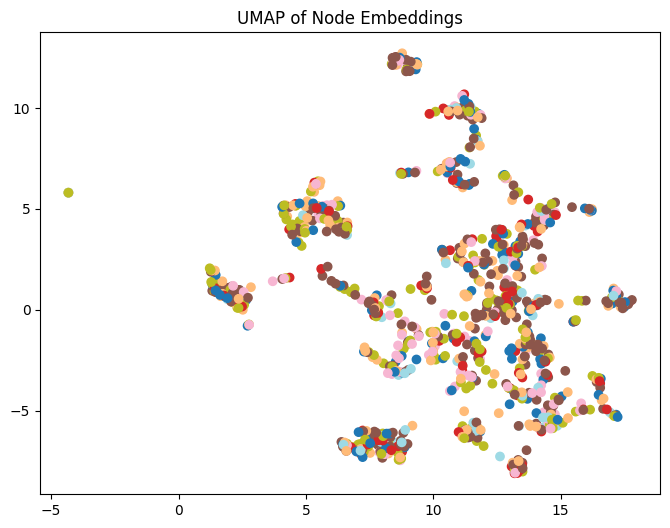

In [39]:
# create a umap for the node embeddings
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(node_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab20')
plt.title('UMAP of Node Embeddings')
plt.show()


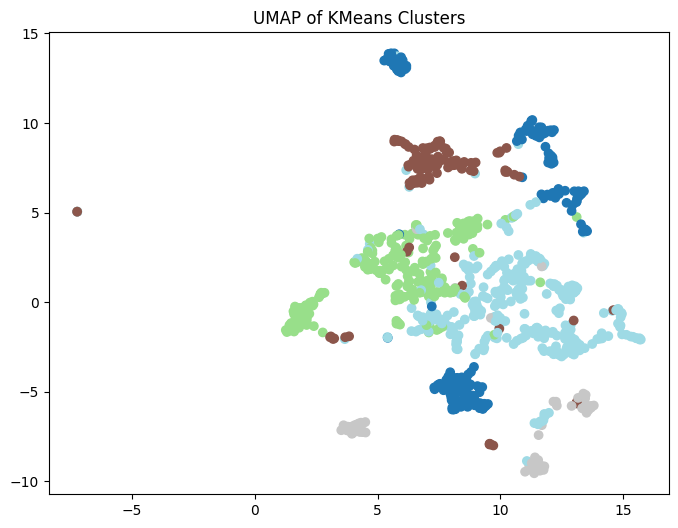

In [40]:
# create a kmeans model for the node embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
cluster_assignments  = kmeans.fit(node_embeddings)
# get the cluster labels
cluster_labels = kmeans.labels_
# create a umap for the cluster labels
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(node_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab20')
plt.title('UMAP of KMeans Clusters')
plt.show()

In [41]:
# show the number of clusters
num_clusters = len(set(cluster_labels))
print(f"The number of clusters detected is {num_clusters}")

The number of clusters detected is 5


In [42]:
# show the nodes in each cluster
cluster_nodes = {cluster: [] for cluster in set(cluster_labels)}
for node, cluster in zip(node_ids, cluster_labels):
    cluster_nodes[cluster].append(node)
# show the nodes in each cluster pretty
for cluster, nodes in cluster_nodes.items():
    print(f"Cluster {cluster} has nodes {nodes}")
    

Cluster 0 has nodes ['114', '115', '96', '165', '169', '44', '28', '971', '170', '498', '409', '113', '93', '438', '141', '367', '116', '23', '11', '7', '19', '362', '30', '856', '417', '506', '338', '455', '263', '27', '339', '40', '12', '318', '35', '48', '358', '29', '443', '441', '427', '466', '430', '499', '421', '245', '31', '261', '47', '361', '213', '464', '38', '525', '661', '452', '171', '161', '151', '36', '504', '707', '569', '24', '9', '423', '437', '265', '337', '264', '370', '135', '8', '529', '251', '336', '37', '39', '123', '359', '25', '26', '32', '229', '444', '266', '700', '655', '332', '608', '406', '754', '360', '34', '547', '33', '407', '590', '485', '136', '442', '847', '900', '981', '470', '545', '602', '976', '823', '699', '502', '720', '496', '566', '922', '913', '666', '860', '500', '816', '588', '76', '914', '374', '510', '75', '293', '753', '570', '765', '573', '324', '267', '674', '247', '246', '527', '925', '953', '555', '487', '956', '501', '119', '505'

In [43]:
# since the clusters are not considerd partion, we can't use the modularity to evaluate the clusters
# we have to implement the modularity from scratch
def calculate_modularity(adjacency_matrix, communities):
    total_edges = np.sum(adjacency_matrix) // 2
    modularity = 0.0
    
    for community in communities.values():
        community = np.array(community)  # Ensure it's a NumPy array
        community_edges = np.sum(adjacency_matrix[community][:, community])
        community_degree = np.sum(np.sum(adjacency_matrix[community], axis=0))
        expected_edges = (community_degree * community_degree) / (2 * total_edges)
        modularity += (community_edges / total_edges) - expected_edges
    
    return modularity
